In [ ]:

import os
import json
import re
import math
from collections import Counter

# Data handling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Hugging Face & Training
import torch
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
import evaluate

# PEFT (LoRA)
from peft import LoraConfig, get_peft_model, TaskType

# Datasets library (if needed for huggingface Dataset)
from datasets import Dataset


In [2]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Using device: cuda


In [ ]:

# Read the sentences file (correct path with subdirectory)
with open('financial_phrasebank/data/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt', 'r', encoding='latin-1') as f:
    lines = f.readlines()

# Parse the data (format: sentence@label)
sentences = []
labels = []

for line in lines:
    if '@' in line:
        parts = line.strip().rsplit('@', 1)
        if len(parts) == 2:
            sentences.append(parts[0])
            labels.append(parts[1].strip())

# Create dataframe
df = pd.DataFrame({'sentence': sentences, 'label': labels})

In [17]:
print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"\nDataset shape: {df.shape}")
print(f"Total articles: {len(df)}")
print(f"\nColumn names: {df.columns.tolist()}")


DATASET OVERVIEW

Dataset shape: (2264, 2)
Total articles: 2264

Column names: ['sentence', 'label']


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2259 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2259 non-null   object
 1   label     2259 non-null   object
dtypes: object(2)
memory usage: 52.9+ KB


In [19]:
print("\n" + "="*70)
print("MISSING VALUES")
print("="*70)
print(df.isnull().sum())
print(f"\nTotal missing: {df.isnull().sum().sum()}")


MISSING VALUES
sentence    0
label       0
dtype: int64

Total missing: 0


In [20]:
print("\n" + "="*70)
print("DUPLICATE CHECK")
print("="*70)

duplicates = df.duplicated(subset=['sentence'])
print(f"Duplicate sentences found: {duplicates.sum()}")



DUPLICATE CHECK
Duplicate sentences found: 5


In [21]:
# DROP DUPLICATES
df = df.drop_duplicates(subset=['sentence'], keep='first')

/tmp/ipython-input-3850416970.py:52: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


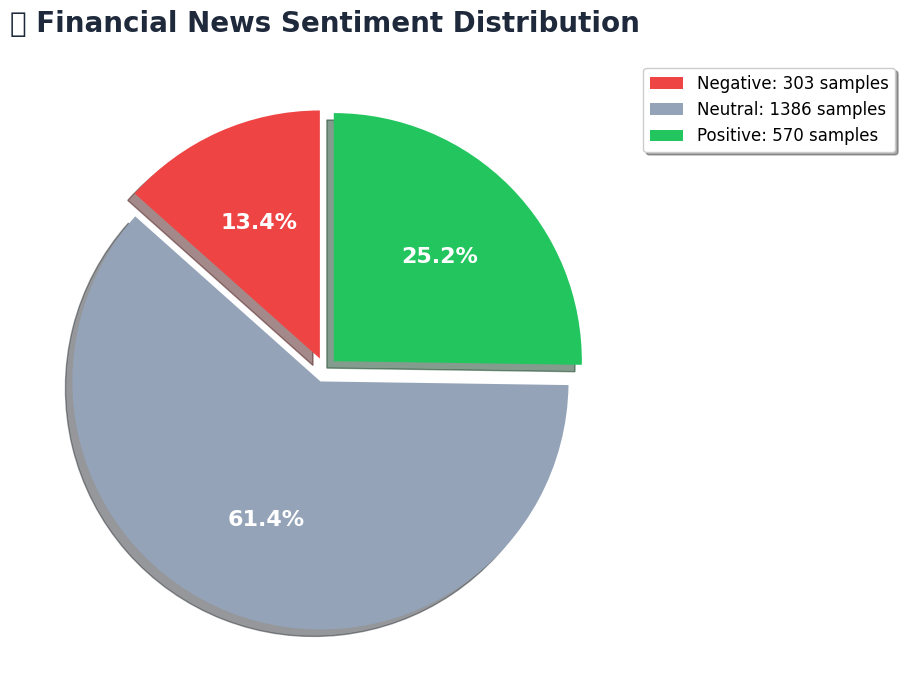


📈 Sentiment Statistics:
Negative  :  303 samples ( 13.4%)
Neutral   : 1386 samples ( 61.4%)
Positive  :  570 samples ( 25.2%)
Total     : 2259 samples


In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Get label counts
label_counts = df['label'].value_counts().sort_index()
label_names = ['Negative', 'Neutral', 'Positive']
colors = ['#ef4444', '#94a3b8', '#22c55e']  # Red, Gray, Green

# Create figure with white background
fig, ax = plt.subplots(figsize=(10, 7), facecolor='white')

# Create pie chart
wedges, texts, autotexts = ax.pie(
    label_counts.values,
    labels=label_names,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=(0.05, 0.05, 0.05),  # Slight separation
    shadow=True,
    textprops={'fontsize': 14, 'weight': 'bold', 'color': 'white'}
)

# Style the percentage text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(16)
    autotext.set_weight('bold')

# Style the labels
for text in texts:
    text.set_fontsize(16)
    text.set_weight('bold')

# Add title
plt.title('📊 Financial News Sentiment Distribution',
          fontsize=20,
          weight='bold',
          pad=20,
          color='#1e293b')

# Add sample counts in legend
legend_labels = [f'{name}: {count} samples'
                 for name, count in zip(label_names, label_counts.values)]
plt.legend(legend_labels,
          loc='upper left',
          bbox_to_anchor=(1, 1),
          fontsize=12,
          frameon=True,
          shadow=True)

plt.tight_layout()
plt.show()

# Print statistics
print("\n📈 Sentiment Statistics:")
print("=" * 40)
for name, count in zip(label_names, label_counts.values):
    percentage = (count / len(df)) * 100
    print(f"{name:10s}: {count:4d} samples ({percentage:5.1f}%)")
print("=" * 40)
print(f"{'Total':10s}: {len(df):4d} samples")

In [ ]:

# Label mapping
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {0: "negative", 1: "neutral", 2: "positive"}

# Load your dataframe (assuming it's already loaded as 'df')
# df = pd.read_csv('your_data.csv')  # uncomment if needed

# Map labels to ids
df['label'] = df['label'].map(label2id)

# Split: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"Train distribution:\n{train_df['label'].value_counts().sort_index()}")

# Calculate class weights
class_counts = train_df['label'].value_counts().sort_index().values
class_weights = len(train_df) / (len(class_counts) * class_counts)
class_weights = torch.FloatTensor(class_weights)
print(f"\nClass weights: {class_weights}")

# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

# LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,  # rank
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"]  # DistilBERT attention layers
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Create datasets
train_dataset = SentimentDataset(
    train_df['sentence'].tolist(),
    train_df['label'].tolist(),
    tokenizer
)
val_dataset = SentimentDataset(
    val_df['sentence'].tolist(),
    val_df['label'].tolist(),
    tokenizer
)
test_dataset = SentimentDataset(
    test_df['sentence'].tolist(),
    test_df['label'].tolist(),
    tokenizer
)

# Custom Trainer with class weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# Metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')

    return {
        'accuracy': acc['accuracy'],
        'f1_macro': f1['f1']
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    learning_rate=2e-4,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
)

# Trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train
print("\n🚀 Starting training...")
trainer.train()

# Evaluate on all sets
print("\n📊 TRAIN SET EVALUATION")
train_results = trainer.evaluate(train_dataset)
print(f"Train Results: {train_results}")
train_preds = trainer.predict(train_dataset)
train_predictions = np.argmax(train_preds.predictions, axis=-1)
print("\nTrain Classification Report:")
print(classification_report(
    train_df['label'].tolist(),
    train_predictions,
    target_names=['negative', 'neutral', 'positive']
))

print("\n" + "="*60)
print("📊 VALIDATION SET EVALUATION")
val_results = trainer.evaluate(val_dataset)
print(f"Val Results: {val_results}")
val_preds = trainer.predict(val_dataset)
val_predictions = np.argmax(val_preds.predictions, axis=-1)
print("\nVal Classification Report:")
print(classification_report(
    val_df['label'].tolist(),
    val_predictions,
    target_names=['negative', 'neutral', 'positive']
))

print("\n" + "="*60)
print(" TEST SET EVALUATION")
test_results = trainer.evaluate(test_dataset)
print(f"Test Results: {test_results}")
test_preds = trainer.predict(test_dataset)
test_predictions = np.argmax(test_preds.predictions, axis=-1)
print("\nTest Classification Report:")
print(classification_report(
    test_df['label'].tolist(),
    test_predictions,
    target_names=['negative', 'neutral', 'positive']
))

print("\n Test Confusion Matrix:")
print(confusion_matrix(test_df['label'].tolist(), test_predictions))

# Save model
model.save_pretrained('./sentiment_lora_model')
tokenizer.save_pretrained('./sentiment_lora_model')
print("\n Model saved to './sentiment_lora_model'")

# Test on financial examples
print("\n" + "="*60)
print("💰 TESTING ON FINANCIAL EXAMPLES")
print("="*60)

financial_examples = [
    "The company's quarterly earnings exceeded expectations, driving stock price up 15%",
    "Revenue declined by 8% year-over-year amid increasing competition",
    "The Federal Reserve maintained interest rates at current levels",
    "Bankruptcy filing announced after failed debt restructuring negotiations",
    "Merger talks ongoing, no definitive agreement reached yet",
    "Record-breaking profits reported in Q4, best performance in company history",
    "Market volatility continues as inflation concerns persist",
    "Dividend payout increased by 20%, rewarding long-term shareholders",
    "Layoffs expected as company struggles with mounting operational costs",
    "Analysts maintain neutral rating pending further financial disclosures"
]

model.eval()
for example in financial_examples:
    inputs = tokenizer(example, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        prediction = torch.argmax(logits, dim=-1).item()
        confidence = probs[0][prediction].item()

    sentiment = id2label[prediction]
    print(f"\n Text: {example}")
    print(f"   Sentiment: {sentiment.upper()} (confidence: {confidence:.2%})")
    print(f"   Probs: [Neg: {probs[0][0]:.2%}, Neu: {probs[0][1]:.2%}, Pos: {probs[0][2]:.2%}]")

Train: 1581, Val: 339, Test: 339
Train distribution:
label
0    212
1    970
2    399
Name: count, dtype: int64

Class weights: tensor([2.4858, 0.5433, 1.3208])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 740,355 || all params: 67,696,134 || trainable%: 1.0936



🚀 Starting training...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tattoumetten (tattoumetten-esprit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.068400,0.613710,0.823009,0.750536
2,0.387000,0.264636,0.917404,0.897105
3,0.221200,0.225208,0.941003,0.922006



📊 TRAIN SET EVALUATION


Train Results: {'eval_loss': 0.16786088049411774, 'eval_accuracy': 0.9468690702087287, 'eval_f1_macro': 0.9280960913305728, 'eval_runtime': 4.9004, 'eval_samples_per_second': 322.626, 'eval_steps_per_second': 10.203, 'epoch': 3.0}

Train Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.95      0.90       212
     neutral       0.98      0.96      0.97       970
    positive       0.91      0.90      0.91       399

    accuracy                           0.95      1581
   macro avg       0.92      0.94      0.93      1581
weighted avg       0.95      0.95      0.95      1581


📊 VALIDATION SET EVALUATION


Val Results: {'eval_loss': 0.22520789504051208, 'eval_accuracy': 0.9410029498525073, 'eval_f1_macro': 0.9220060507685391, 'eval_runtime': 0.6458, 'eval_samples_per_second': 524.928, 'eval_steps_per_second': 17.033, 'epoch': 3.0}

Val Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.93      0.90        45
     neutral       0.97      0.97      0.97       208
    positive       0.90      0.88      0.89        86

    accuracy                           0.94       339
   macro avg       0.92      0.93      0.92       339
weighted avg       0.94      0.94      0.94       339


📊 TEST SET EVALUATION


Test Results: {'eval_loss': 0.16845360398292542, 'eval_accuracy': 0.943952802359882, 'eval_f1_macro': 0.9308152479144303, 'eval_runtime': 0.6541, 'eval_samples_per_second': 518.284, 'eval_steps_per_second': 16.817, 'epoch': 3.0}

Test Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.98      0.93        46
     neutral       0.99      0.95      0.97       208
    positive       0.88      0.92      0.90        85

    accuracy                           0.94       339
   macro avg       0.92      0.95      0.93       339
weighted avg       0.95      0.94      0.94       339


🎯 Test Confusion Matrix:
[[ 45   0   1]
 [  1 197  10]
 [  5   2  78]]

✅ Model saved to './sentiment_lora_model'

💰 TESTING ON FINANCIAL EXAMPLES

📝 Text: The company's quarterly earnings exceeded expectations, driving stock price up 15%
   Sentiment: POSITIVE (confidence: 80.01%)
   Probs: [Neg: 19.69%, Neu: 0.30%, Pos: 80.01%]

📝 Text: Revenue declined by